In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v2 import Autoencoder
from tools.ESN_v2 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-21 21:05:20.345142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:20.345788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.233585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.234216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.234755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.298576: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 21:05:22.305221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.305831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:05:22.306362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '013'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ConvESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
data_dir_idx: 000
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
delta_t = 1.
T = t_recorded_samples[-1]

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [17]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [18]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [19]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [20]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1:], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

2023-02-21 21:05:41.368580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
# num_latent_states = latent_states_all.shape[1]

2023-02-21 21:05:47.804693: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 666660000 exceeds 10% of free system memory.
2023-02-21 21:05:48.369657: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 666660000 exceeds 10% of free system memory.


In [22]:
temp_ = latent_states_all.reshape(latent_states_all.shape[0], -1)
time_stddev_AEproducedlatentstates = np.std(temp_, axis=0)

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.25
    num_input_tsteps = 100
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [13*13*200]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [3]
    rho_res = [0.6]
    usebias_Win = [False]
    alpha = [0.99]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'linear'
    use_weights_post_dense = False
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]        

    # saving simulation data
    sim_data = {
        'T':T,
        'delta_t':delta_t,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
og_ls_shape = latent_states_all.shape
latent_states_all = latent_states_all.reshape((latent_states_all.shape[0], -1))

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    [latent_states_all.shape[0]],#boundary_idx_arr,
    dt_rnn,#delta_t,
    #params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (330, 100, 169)
data_rnn_output.shape :  (330, 100, 169)


In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
# data_rnn_input = data_rnn_input.reshape(data_rnn_input.shape[0:2]+og_ls_shape[1:])
# data_rnn_output = data_rnn_output.reshape(data_rnn_output.shape[0:2]+og_ls_shape[1:])

In [29]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (330, 100, 169)
data_rnn_output.shape :  (330, 100, 169)


In [30]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    lambda_reg = 5e-6 # weight for regularizer
    min_delta = 1e-6
    patience = 50
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 1/100

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [31]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]
rnn_data_boundary_idx_arr

array([330])

In [32]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_samples = batch_size*int(num_samples/batch_size)
    num_train_arr[i] = batch_size * int(np.round(train_split*num_samples/batch_size))
    num_val_arr[i] = batch_size * int(np.round(val_split*num_samples/batch_size))
    num_test_arr[i] = num_samples - num_train_arr[i] - num_val_arr[i]
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]

    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]

        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    training_data_rolling_count += num_train

    val_data_rolling_count += num_val

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [33]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (256, 100, 169)
 testing_data_rnn_input.shape :  (32, 100, 169)
     val_data_rnn_input.shape :  (32, 100, 169)


In [34]:
print('training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print(' testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('     val_data_rnn_output.shape : ', val_data_rnn_output.shape)

training_data_rnn_output.shape :  (256, 100, 169)
 testing_data_rnn_output.shape :  (32, 100, 169)
     val_data_rnn_output.shape :  (32, 100, 169)


In [35]:
# print(rnn_data_boundary_idx_arr)

In [36]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    data_dim = training_data_rnn_input.shape[-1]


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(batch_size,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33173722
stddev : 0.0033173722028732302


In [37]:
time_stddev.shape

(169,)

In [38]:
# time_stddev = time_stddev.reshape(og_ls_shape[1:])

In [39]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [40]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [41]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [42]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.6874 - mse: 0.6857 - NMSE: 6.1709 - tot_time: 0h 0m 16.9s

Epoch 1: val_NMSE improved from inf to 5.17424, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 770ms/step - loss: 0.6874 - mse: 0.6857 - NMSE: 6.1709 - val_loss: 0.5766 - val_mse: 0.5749 - val_NMSE: 5.1742
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.3210 - mse: 0.3193 - NMSE: 2.8733 - tot_time: 0h 0m 28.8s

Epoch 2: val_NMSE improved from 5.17424 to 2.056

Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0019 - NMSE: 0.0175 - tot_time: 0h 3m 4.7s

Epoch 15: val_NMSE did not improve from 0.03041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 703ms/step - loss: 0.0035 - mse: 0.0019 - NMSE: 0.0175 - val_loss: 0.0051 - val_mse: 0.0035 - val_NMSE: 0.0317
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0018 - NMSE: 0.0161 - tot_time: 0h 3m 16.1s

Epoch 16: val_NMSE improved from 0.03041 to 0.02324, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 752ms/step - loss: 0.0034 - mse: 0.0018 - NMSE: 0.0161 - val_loss: 

Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 0.0023 - mse: 8.1629e-04 - NMSE: 0.0073 - tot_time: 0h 6m 1.3s

Epoch 30: val_NMSE improved from 0.01352 to 0.01324, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 733ms/step - loss: 0.0023 - mse: 8.1629e-04 - NMSE: 0.0073 - val_loss: 0.0029 - val_mse: 0.0015 - val_NMSE: 0.0132
Epoch 31/1000
16/16 [==============================] - ETA: 0s - loss: 0.0023 - mse: 8.0540e-04 - NMSE: 0.0072 - tot_time: 0h 6m 13.1s

Epoch 31: val_NMSE improved from 0.01324 to 0.01294, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistories

16/16 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0054 - NMSE: 0.0486 - tot_time: 0h 9m 4.2s

Epoch 46: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 722ms/step - loss: 0.0067 - mse: 0.0054 - NMSE: 0.0486 - val_loss: 0.0106 - val_mse: 0.0092 - val_NMSE: 0.0831
Epoch 47/1000
16/16 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0045 - NMSE: 0.0407 - tot_time: 0h 9m 15.4s

Epoch 47: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 708ms/step - loss: 0.0058 - mse: 0.0045 - NMSE: 0.0407 - val_loss: 0.0070 - val_mse: 0.0057 - val_NMSE: 0.0515
Epoch 48/1000
16/16 [==============================] - ETA: 0s - loss: 0.0063 - m

Epoch 64/1000
16/16 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0304 - NMSE: 0.2739 - tot_time: 0h 12m 26.6s

Epoch 64: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 706ms/step - loss: 0.0316 - mse: 0.0304 - NMSE: 0.2739 - val_loss: 0.0546 - val_mse: 0.0534 - val_NMSE: 0.4803
Epoch 65/1000
16/16 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0322 - NMSE: 0.2902 - tot_time: 0h 12m 37.8s

Epoch 65: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 706ms/step - loss: 0.0335 - mse: 0.0322 - NMSE: 0.2902 - val_loss: 0.0591 - val_mse: 0.0579 - val_NMSE: 0.5213
Epoch 66/1000
16/16 [==============================] - ETA: 0s -

Epoch 82/1000
16/16 [==============================] - ETA: 0s - loss: 0.0546 - mse: 0.0535 - NMSE: 0.4811 - tot_time: 0h 15m 49.6s

Epoch 82: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 708ms/step - loss: 0.0546 - mse: 0.0535 - NMSE: 0.4811 - val_loss: 0.0803 - val_mse: 0.0791 - val_NMSE: 0.7121
Epoch 83/1000
16/16 [==============================] - ETA: 0s - loss: 0.0566 - mse: 0.0555 - NMSE: 0.4993 - tot_time: 0h 16m 0.9s

Epoch 83: val_NMSE did not improve from 0.01241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 711ms/step - loss: 0.0566 - mse: 0.0555 - NMSE: 0.4993 - val_loss: 0.0774 - val_mse: 0.0762 - val_NMSE: 0.6858
Epoch 84/1000
16/16 [==============================] - ETA: 0s - 

16/16 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.8708e-04 - NMSE: 0.0044 - tot_time: 0h 18m 35.5s

Epoch 12: val_NMSE improved from 0.00576 to 0.00571, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 757ms/step - loss: 0.0019 - mse: 4.8708e-04 - NMSE: 0.0044 - val_loss: 0.0020 - val_mse: 6.3415e-04 - val_NMSE: 0.0057
Epoch 13/1000
16/16 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.8153e-04 - NMSE: 0.0043 - tot_time: 0h 18m 47.2s

Epoch 13: val_NMSE improved from 0.00571 to 0.00566, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpo

Epoch 26/1000
16/16 [==============================] - ETA: 0s - loss: 0.0018 - mse: 4.2661e-04 - NMSE: 0.0038 - tot_time: 0h 21m 21.5s

Epoch 26: val_NMSE improved from 0.00513 to 0.00509, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 14s 857ms/step - loss: 0.0018 - mse: 4.2661e-04 - NMSE: 0.0038 - val_loss: 0.0020 - val_mse: 5.6573e-04 - val_NMSE: 0.0051
Epoch 27/1000
16/16 [==============================] - ETA: 0s - loss: 0.0018 - mse: 4.2331e-04 - NMSE: 0.0038 - tot_time: 0h 21m 34.8s

Epoch 27: val_NMSE improved from 0.00509 to 0.00505, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 40/1000
16/16 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.8644e-04 - NMSE: 0.0035 - tot_time: 0h 24m 6.8s

Epoch 40: val_NMSE improved from 0.00466 to 0.00463, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 752ms/step - loss: 0.0018 - mse: 3.8644e-04 - NMSE: 0.0035 - val_loss: 0.0019 - val_mse: 5.1494e-04 - val_NMSE: 0.0046
Epoch 41/1000
16/16 [==============================] - ETA: 0s - loss: 0.0018 - mse: 3.8400e-04 - NMSE: 0.0035 - tot_time: 0h 24m 18.5s

Epoch 41: val_NMSE improved from 0.00463 to 0.00461, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHis

Epoch 54/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 3.5638e-04 - NMSE: 0.0032 - tot_time: 0h 26m 51.6s

Epoch 54: val_NMSE improved from 0.00432 to 0.00430, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 734ms/step - loss: 0.0017 - mse: 3.5638e-04 - NMSE: 0.0032 - val_loss: 0.0018 - val_mse: 4.7749e-04 - val_NMSE: 0.0043
Epoch 55/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 3.5462e-04 - NMSE: 0.0032 - tot_time: 0h 27m 3.0s

Epoch 55: val_NMSE improved from 0.00430 to 0.00428, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHis

Epoch 68/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 3.3219e-04 - NMSE: 0.0030 - tot_time: 0h 29m 37.8s

Epoch 68: val_NMSE improved from 0.00405 to 0.00403, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 759ms/step - loss: 0.0017 - mse: 3.3219e-04 - NMSE: 0.0030 - val_loss: 0.0018 - val_mse: 4.4779e-04 - val_NMSE: 0.0040
Epoch 69/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 3.3055e-04 - NMSE: 0.0030 - tot_time: 0h 29m 49.9s

Epoch 69: val_NMSE improved from 0.00403 to 0.00401, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 82/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.1106e-04 - NMSE: 0.0028 - tot_time: 0h 32m 21.7s

Epoch 82: val_NMSE improved from 0.00381 to 0.00380, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 750ms/step - loss: 0.0016 - mse: 3.1106e-04 - NMSE: 0.0028 - val_loss: 0.0017 - val_mse: 4.2190e-04 - val_NMSE: 0.0038
Epoch 83/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 3.0969e-04 - NMSE: 0.0028 - tot_time: 0h 32m 33.5s

Epoch 83: val_NMSE improved from 0.00380 to 0.00378, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 96/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 2.9223e-04 - NMSE: 0.0026 - tot_time: 0h 35m 7.1s

Epoch 96: val_NMSE improved from 0.00360 to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 758ms/step - loss: 0.0016 - mse: 2.9223e-04 - NMSE: 0.0026 - val_loss: 0.0017 - val_mse: 3.9902e-04 - val_NMSE: 0.0036
Epoch 97/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 2.9096e-04 - NMSE: 0.0026 - tot_time: 0h 35m 18.9s

Epoch 97: val_NMSE improved from 0.00359 to 0.00357, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHis

Epoch 110/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.7427e-04 - NMSE: 0.0025 - tot_time: 0h 37m 55.1s

Epoch 110: val_NMSE improved from 0.00341 to 0.00339, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 750ms/step - loss: 0.0015 - mse: 2.7427e-04 - NMSE: 0.0025 - val_loss: 0.0016 - val_mse: 3.7674e-04 - val_NMSE: 0.0034
Epoch 111/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.7309e-04 - NMSE: 0.0025 - tot_time: 0h 38m 6.7s

Epoch 111: val_NMSE improved from 0.00339 to 0.00338, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Los

Epoch 124/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.5850e-04 - NMSE: 0.0023 - tot_time: 0h 40m 40.4s

Epoch 124: val_NMSE improved from 0.00322 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 746ms/step - loss: 0.0015 - mse: 2.5850e-04 - NMSE: 0.0023 - val_loss: 0.0016 - val_mse: 3.5654e-04 - val_NMSE: 0.0032
Epoch 125/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.5747e-04 - NMSE: 0.0023 - tot_time: 0h 40m 52.2s

Epoch 125: val_NMSE improved from 0.00321 to 0.00319, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Lo

Epoch 138/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.4704e-04 - NMSE: 0.0022 - tot_time: 0h 43m 26.5s

Epoch 138: val_NMSE improved from 0.00308 to 0.00307, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 746ms/step - loss: 0.0015 - mse: 2.4704e-04 - NMSE: 0.0022 - val_loss: 0.0016 - val_mse: 3.4150e-04 - val_NMSE: 0.0031
Epoch 139/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 2.4638e-04 - NMSE: 0.0022 - tot_time: 0h 43m 38.2s

Epoch 139: val_NMSE improved from 0.00307 to 0.00307, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Lo

16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 2.3780e-04 - NMSE: 0.0021 - tot_time: 0h 46m 12.0s

Epoch 152: val_NMSE improved from 0.00299 to 0.00299, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 754ms/step - loss: 0.0014 - mse: 2.3780e-04 - NMSE: 0.0021 - val_loss: 0.0015 - val_mse: 3.3204e-04 - val_NMSE: 0.0030
Epoch 153/1000
16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 2.3718e-04 - NMSE: 0.0021 - tot_time: 0h 46m 24.0s

Epoch 153: val_NMSE improved from 0.00299 to 0.00298, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesChec

Epoch 166/1000
16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 2.2507e-04 - NMSE: 0.0020 - tot_time: 0h 48m 56.9s

Epoch 166: val_NMSE improved from 0.00289 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 735ms/step - loss: 0.0014 - mse: 2.2507e-04 - NMSE: 0.0020 - val_loss: 0.0015 - val_mse: 3.2125e-04 - val_NMSE: 0.0029
Epoch 167/1000
16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 2.2403e-04 - NMSE: 0.0020 - tot_time: 0h 49m 8.6s

Epoch 167: val_NMSE improved from 0.00289 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Los

Epoch 180/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.1027e-04 - NMSE: 0.0019 - tot_time: 0h 51m 41.7s

Epoch 180: val_NMSE improved from 0.00279 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 722ms/step - loss: 0.0013 - mse: 2.1027e-04 - NMSE: 0.0019 - val_loss: 0.0014 - val_mse: 3.0834e-04 - val_NMSE: 0.0028
Epoch 181/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.0923e-04 - NMSE: 0.0019 - tot_time: 0h 51m 53.4s

Epoch 181: val_NMSE improved from 0.00278 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Lo

16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.9687e-04 - NMSE: 0.0018 - tot_time: 0h 54m 25.9s

Epoch 194: val_NMSE improved from 0.00268 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 728ms/step - loss: 0.0013 - mse: 1.9687e-04 - NMSE: 0.0018 - val_loss: 0.0014 - val_mse: 2.9612e-04 - val_NMSE: 0.0027
Epoch 195/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 1.9566e-04 - NMSE: 0.0018 - tot_time: 0h 54m 37.7s

Epoch 195: val_NMSE improved from 0.00267 to 0.00265, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesChec

16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.8314e-04 - NMSE: 0.0016 - tot_time: 0h 57m 8.5s

Epoch 208: val_NMSE improved from 0.00252 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 724ms/step - loss: 0.0012 - mse: 1.8314e-04 - NMSE: 0.0016 - val_loss: 0.0013 - val_mse: 2.7870e-04 - val_NMSE: 0.0025
Epoch 209/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.8239e-04 - NMSE: 0.0016 - tot_time: 0h 57m 20.4s

Epoch 209: val_NMSE improved from 0.00251 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheck

Epoch 222/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.7268e-04 - NMSE: 0.0016 - tot_time: 0h 59m 53.9s

Epoch 222: val_NMSE improved from 0.00240 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 732ms/step - loss: 0.0012 - mse: 1.7268e-04 - NMSE: 0.0016 - val_loss: 0.0013 - val_mse: 2.6547e-04 - val_NMSE: 0.0024
Epoch 223/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 1.7209e-04 - NMSE: 0.0015 - tot_time: 1h 0m 5.7s

Epoch 223: val_NMSE improved from 0.00239 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 699ms/step - loss: 0.0011 - mse: 1.6554e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 2.5787e-04 - val_NMSE: 0.0023
Epoch 237/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.6534e-04 - NMSE: 0.0015 - tot_time: 1h 2m 48.0s

Epoch 237: val_NMSE improved from 0.00232 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 740ms/step - loss: 0.0011 - mse: 1.6534e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 2.5702e-04 - val_NMSE: 0.0023
Epoch 238/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.6500e-04 - NMSE: 0.0015 -

Epoch 253/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.7012e-04 - NMSE: 0.0015 - tot_time: 1h 5m 48.9s

Epoch 253: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 709ms/step - loss: 0.0011 - mse: 1.7012e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 2.6808e-04 - val_NMSE: 0.0024
Epoch 254/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.7124e-04 - NMSE: 0.0015 - tot_time: 1h 6m 0.3s

Epoch 254: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 715ms/step - loss: 0.0011 - mse: 1.7124e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 2.7008e-04 - val_NMSE: 0.0024
Epoch 255/1000
16/16 [=================

16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 2.2514e-04 - NMSE: 0.0020 - tot_time: 1h 9m 2.1s

Epoch 270: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 740ms/step - loss: 0.0011 - mse: 2.2514e-04 - NMSE: 0.0020 - val_loss: 0.0012 - val_mse: 3.5063e-04 - val_NMSE: 0.0032
Epoch 271/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 2.3174e-04 - NMSE: 0.0021 - tot_time: 1h 9m 13.5s

Epoch 271: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 717ms/step - loss: 0.0011 - mse: 2.3174e-04 - NMSE: 0.0021 - val_loss: 0.0013 - val_mse: 3.7125e-04 - val_NMSE: 0.0033
Epoch 272/1000
16/16 [==============================] 

16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 4.6030e-04 - NMSE: 0.0041 - tot_time: 1h 12m 13.1s

Epoch 287: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 697ms/step - loss: 0.0013 - mse: 4.6030e-04 - NMSE: 0.0041 - val_loss: 0.0015 - val_mse: 6.7227e-04 - val_NMSE: 0.0061
Epoch 288/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 4.8034e-04 - NMSE: 0.0043 - tot_time: 1h 12m 24.2s

Epoch 288: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 708ms/step - loss: 0.0013 - mse: 4.8034e-04 - NMSE: 0.0043 - val_loss: 0.0015 - val_mse: 6.7190e-04 - val_NMSE: 0.0060
Epoch 289/1000
16/16 [=============================

Epoch 12/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.5482e-04 - NMSE: 0.0014 - tot_time: 1h 15m 0.6s

Epoch 12: val_NMSE improved from 0.00198 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 782ms/step - loss: 0.0011 - mse: 1.5482e-04 - NMSE: 0.0014 - val_loss: 0.0012 - val_mse: 2.2029e-04 - val_NMSE: 0.0020
Epoch 13/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.5453e-04 - NMSE: 0.0014 - tot_time: 1h 15m 12.8s

Epoch 13: val_NMSE improved from 0.00198 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHis

Epoch 26/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.5110e-04 - NMSE: 0.0014 - tot_time: 1h 17m 51.7s

Epoch 26: val_NMSE improved from 0.00195 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 745ms/step - loss: 0.0011 - mse: 1.5110e-04 - NMSE: 0.0014 - val_loss: 0.0012 - val_mse: 2.1688e-04 - val_NMSE: 0.0020
Epoch 27/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.5078e-04 - NMSE: 0.0014 - tot_time: 1h 18m 3.4s

Epoch 27: val_NMSE improved from 0.00195 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHis

Epoch 40/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4808e-04 - NMSE: 0.0013 - tot_time: 1h 20m 40.0s

Epoch 40: val_NMSE improved from 0.00192 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 750ms/step - loss: 0.0011 - mse: 1.4808e-04 - NMSE: 0.0013 - val_loss: 0.0012 - val_mse: 2.1336e-04 - val_NMSE: 0.0019
Epoch 41/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4793e-04 - NMSE: 0.0013 - tot_time: 1h 20m 52.0s

Epoch 41: val_NMSE improved from 0.00192 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 54/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4551e-04 - NMSE: 0.0013 - tot_time: 1h 23m 27.8s

Epoch 54: val_NMSE improved from 0.00189 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 750ms/step - loss: 0.0011 - mse: 1.4551e-04 - NMSE: 0.0013 - val_loss: 0.0012 - val_mse: 2.0984e-04 - val_NMSE: 0.0019
Epoch 55/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4533e-04 - NMSE: 0.0013 - tot_time: 1h 23m 39.9s

Epoch 55: val_NMSE improved from 0.00189 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 68/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4329e-04 - NMSE: 0.0013 - tot_time: 1h 26m 36.1s

Epoch 68: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 727ms/step - loss: 0.0011 - mse: 1.4329e-04 - NMSE: 0.0013 - val_loss: 0.0012 - val_mse: 2.0674e-04 - val_NMSE: 0.0019
Epoch 69/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4310e-04 - NMSE: 0.0013 - tot_time: 1h 26m 47.6s

Epoch 69: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 82/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4127e-04 - NMSE: 0.0013 - tot_time: 1h 29m 19.4s

Epoch 82: val_NMSE improved from 0.00184 to 0.00184, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 723ms/step - loss: 0.0011 - mse: 1.4127e-04 - NMSE: 0.0013 - val_loss: 0.0011 - val_mse: 2.0394e-04 - val_NMSE: 0.0018
Epoch 83/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.4110e-04 - NMSE: 0.0013 - tot_time: 1h 29m 30.8s

Epoch 83: val_NMSE improved from 0.00184 to 0.00183, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 96/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.3942e-04 - NMSE: 0.0013 - tot_time: 1h 32m 16.7s

Epoch 96: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 14s 866ms/step - loss: 0.0011 - mse: 1.3942e-04 - NMSE: 0.0013 - val_loss: 0.0011 - val_mse: 2.0123e-04 - val_NMSE: 0.0018
Epoch 97/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.3920e-04 - NMSE: 0.0013 - tot_time: 1h 32m 30.6s

Epoch 97: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHi

Epoch 110/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.3759e-04 - NMSE: 0.0012 - tot_time: 1h 35m 23.2s

Epoch 110: val_NMSE improved from 0.00179 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 15s 889ms/step - loss: 0.0011 - mse: 1.3759e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9869e-04 - val_NMSE: 0.0018
Epoch 111/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 1.3747e-04 - NMSE: 0.0012 - tot_time: 1h 35m 37.4s

Epoch 111: val_NMSE improved from 0.00179 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 14s 862ms/step - loss: 0.0010 - mse: 1.3590e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9622e-04 - val_NMSE: 0.0018
Epoch 125/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3578e-04 - NMSE: 0.0012 - tot_time: 1h 38m 39.3s

Epoch 125: val_NMSE improved from 0.00177 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 975ms/step - loss: 0.0010 - mse: 1.3578e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9604e-04 - val_NMSE: 0.0018
Epoch 126/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3558e-04 - NMSE: 0.0012 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 722ms/step - loss: 0.0010 - mse: 1.3410e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9389e-04 - val_NMSE: 0.0017
Epoch 139/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3405e-04 - NMSE: 0.0012 - tot_time: 1h 41m 33.5s

Epoch 139: val_NMSE improved from 0.00174 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 690ms/step - loss: 0.0010 - mse: 1.3405e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9364e-04 - val_NMSE: 0.0017
Epoch 140/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3387e-04 - NMSE: 0.0012 

Epoch 153/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3225e-04 - NMSE: 0.0012 - tot_time: 1h 44m 29.4s

Epoch 153: val_NMSE improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 0.0010 - mse: 1.3225e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.9131e-04 - val_NMSE: 0.0017
Epoch 154/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3215e-04 - NMSE: 0.0012 - tot_time: 1h 44m 45.7s

Epoch 154: val_NMSE improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossH

Epoch 167/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3059e-04 - NMSE: 0.0012 - tot_time: 1h 48m 13.7s

Epoch 167: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 0.0010 - mse: 1.3059e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 1.8903e-04 - val_NMSE: 0.0017
Epoch 168/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 1.3041e-04 - NMSE: 0.0012 - tot_time: 1h 48m 30.6s

Epoch 168: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossH

Epoch 182/1000
16/16 [==============================] - ETA: 0s - loss: 9.9118e-04 - mse: 1.2880e-04 - NMSE: 0.0012 - tot_time: 1h 52m 14.0s

Epoch 182: val_NMSE improved from 0.00168 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.9118e-04 - mse: 1.2880e-04 - NMSE: 0.0012 - val_loss: 0.0010 - val_mse: 1.8655e-04 - val_NMSE: 0.0017
Epoch 183/1000
16/16 [==============================] - ETA: 0s - loss: 9.9012e-04 - mse: 1.2865e-04 - NMSE: 0.0012 - tot_time: 1h 52m 30.6s

Epoch 183: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 979ms/step - loss: 9.9012e-04 - mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 9.7657e-04 - mse: 1.2725e-04 - NMSE: 0.0011 - val_loss: 0.0010 - val_mse: 1.8421e-04 - val_NMSE: 0.0017
Epoch 197/1000
16/16 [==============================] - ETA: 0s - loss: 9.7556e-04 - mse: 1.2719e-04 - NMSE: 0.0011 - tot_time: 1h 56m 10.3s

Epoch 197: val_NMSE improved from 0.00166 to 0.00166, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 9.7556e-04 - mse: 1.2719e-04 - NMSE: 0.0011 - val_loss: 0.0010 - val_mse: 1.8393e-04 - val_NMSE: 0.0017
Epoch 198/1000
16/16 [==============================] - ETA: 0s - loss: 9.7457e-04 - mse: 1.2716e-04 - NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 9.6144e-04 - mse: 1.2564e-04 - NMSE: 0.0011 - val_loss: 0.0010 - val_mse: 1.8180e-04 - val_NMSE: 0.0016
Epoch 211/1000
16/16 [==============================] - ETA: 0s - loss: 9.6035e-04 - mse: 1.2552e-04 - NMSE: 0.0011 - tot_time: 1h 59m 53.8s

Epoch 211: val_NMSE improved from 0.00164 to 0.00163, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 9.6035e-04 - mse: 1.2552e-04 - NMSE: 0.0011 - val_loss: 0.0010 - val_mse: 1.8150e-04 - val_NMSE: 0.0016
Epoch 212/1000
16/16 [==============================] - ETA: 0s - loss: 9.5928e-04 - mse: 1.2543e-04 - NMS

Epoch 225/1000
16/16 [==============================] - ETA: 0s - loss: 9.4446e-04 - mse: 1.2352e-04 - NMSE: 0.0011 - tot_time: 2h 3m 35.4s

Epoch 225: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.4446e-04 - mse: 1.2352e-04 - NMSE: 0.0011 - val_loss: 0.0010 - val_mse: 1.7970e-04 - val_NMSE: 0.0016
Epoch 226/1000
16/16 [==============================] - ETA: 0s - loss: 9.4331e-04 - mse: 1.2337e-04 - NMSE: 0.0011 - tot_time: 2h 3m 52.3s

Epoch 226: val_NMSE improved from 0.00162 to 0.00161, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 9.4331e-04 - mse: 1.2

Epoch 240/1000
16/16 [==============================] - ETA: 0s - loss: 9.2768e-04 - mse: 1.2192e-04 - NMSE: 0.0011 - tot_time: 2h 6m 41.5s

Epoch 240: val_NMSE improved from 0.00160 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 720ms/step - loss: 9.2768e-04 - mse: 1.2192e-04 - NMSE: 0.0011 - val_loss: 9.8252e-04 - val_mse: 1.7730e-04 - val_NMSE: 0.0016
Epoch 241/1000
16/16 [==============================] - ETA: 0s - loss: 9.2651e-04 - mse: 1.2177e-04 - NMSE: 0.0011 - tot_time: 2h 6m 53.0s

Epoch 241: val_NMSE improved from 0.00160 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/

16/16 [==============================] - ETA: 0s - loss: 9.1084e-04 - mse: 1.2046e-04 - NMSE: 0.0011 - tot_time: 2h 9m 34.7s

Epoch 255: val_NMSE improved from 0.00158 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 750ms/step - loss: 9.1084e-04 - mse: 1.2046e-04 - NMSE: 0.0011 - val_loss: 9.6552e-04 - val_mse: 1.7569e-04 - val_NMSE: 0.0016
Epoch 256/1000
16/16 [==============================] - ETA: 0s - loss: 9.0963e-04 - mse: 1.2028e-04 - NMSE: 0.0011 - tot_time: 2h 9m 46.5s

Epoch 256: val_NMSE improved from 0.00158 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/Los

16/16 [==============================] - ETA: 0s - loss: 8.9306e-04 - mse: 1.1812e-04 - NMSE: 0.0011 - tot_time: 2h 12m 31.9s

Epoch 270: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 743ms/step - loss: 8.9306e-04 - mse: 1.1812e-04 - NMSE: 0.0011 - val_loss: 9.4762e-04 - val_mse: 1.7323e-04 - val_NMSE: 0.0016
Epoch 271/1000
16/16 [==============================] - ETA: 0s - loss: 8.9186e-04 - mse: 1.1796e-04 - NMSE: 0.0011 - tot_time: 2h 12m 43.4s

Epoch 271: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 724ms/step - loss: 8.9186e-04 - mse: 1.1796e-04 - NMSE: 0.0011 - val_loss: 9.4668e-04 - val_mse: 1.7332e-04 - val_NMSE: 0.0016
Epoch 272/1000
16/16 [=====

Epoch 285/1000
16/16 [==============================] - ETA: 0s - loss: 8.7534e-04 - mse: 1.1584e-04 - NMSE: 0.0010 - tot_time: 2h 15m 30.4s

Epoch 285: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 736ms/step - loss: 8.7534e-04 - mse: 1.1584e-04 - NMSE: 0.0010 - val_loss: 9.2882e-04 - val_mse: 1.6986e-04 - val_NMSE: 0.0015
Epoch 286/1000
16/16 [==============================] - ETA: 0s - loss: 8.7421e-04 - mse: 1.1574e-04 - NMSE: 0.0010 - tot_time: 2h 15m 42.0s

Epoch 286: val_NMSE improved from 0.00153 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 757ms/step - loss: 8.7421e-0

Epoch 301/1000
16/16 [==============================] - ETA: 0s - loss: 8.5910e-04 - mse: 1.1595e-04 - NMSE: 0.0010 - tot_time: 2h 18m 38.5s

Epoch 301: val_NMSE did not improve from 0.00152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 734ms/step - loss: 8.5910e-04 - mse: 1.1595e-04 - NMSE: 0.0010 - val_loss: 9.1284e-04 - val_mse: 1.7023e-04 - val_NMSE: 0.0015
Epoch 302/1000
16/16 [==============================] - ETA: 0s - loss: 8.5790e-04 - mse: 1.1577e-04 - NMSE: 0.0010 - tot_time: 2h 18m 50.2s

Epoch 302: val_NMSE did not improve from 0.00152
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 739ms/step - loss: 8.5790e-04 - mse: 1.1577e-04 - NMSE: 0.0010 - val_loss: 9.1144e-04 - val_mse: 1.6983e-04 - val_NMSE: 0.0015
Epoch 303/10

Epoch 317/1000
16/16 [==============================] - ETA: 0s - loss: 8.4023e-04 - mse: 1.1313e-04 - NMSE: 0.0010 - tot_time: 2h 21m 46.9s

Epoch 317: val_NMSE improved from 0.00150 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 771ms/step - loss: 8.4023e-04 - mse: 1.1313e-04 - NMSE: 0.0010 - val_loss: 8.9270e-04 - val_mse: 1.6613e-04 - val_NMSE: 0.0015
Epoch 318/1000
16/16 [==============================] - ETA: 0s - loss: 8.3886e-04 - mse: 1.1275e-04 - NMSE: 0.0010 - tot_time: 2h 21m 58.9s

Epoch 318: val_NMSE improved from 0.00150 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_00

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 773ms/step - loss: 8.2472e-04 - mse: 1.1233e-04 - NMSE: 0.0010 - val_loss: 8.7605e-04 - val_mse: 1.6417e-04 - val_NMSE: 0.0015
Epoch 333/1000
16/16 [==============================] - ETA: 0s - loss: 8.2353e-04 - mse: 1.1210e-04 - NMSE: 0.0010 - tot_time: 2h 24m 54.5s

Epoch 333: val_NMSE improved from 0.00148 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 758ms/step - loss: 8.2353e-04 - mse: 1.1210e-04 - NMSE: 0.0010 - val_loss: 8.7449e-04 - val_mse: 1.6357e-04 - val_NMSE: 0.0015
Epoch 334/1000
16/16 [==============================] - ETA: 0s - loss: 8.2215e-04 - mse: 1.

Epoch 349/1000
16/16 [==============================] - ETA: 0s - loss: 8.0727e-04 - mse: 1.1102e-04 - NMSE: 9.9922e-04 - tot_time: 2h 29m 19.1s

Epoch 349: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 8.0727e-04 - mse: 1.1102e-04 - NMSE: 9.9922e-04 - val_loss: 8.6111e-04 - val_mse: 1.6536e-04 - val_NMSE: 0.0015
Epoch 350/1000
16/16 [==============================] - ETA: 0s - loss: 8.0589e-04 - mse: 1.1058e-04 - NMSE: 9.9521e-04 - tot_time: 2h 29m 37.3s

Epoch 350: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 8.0589e-04 - mse: 1.1058e-04 - NMSE: 9.9521e-04 - val_loss: 8.5968e-04 - val_mse: 1.6486e-04 - val_NMSE: 0.0015
Ep

Epoch 365/1000
16/16 [==============================] - ETA: 0s - loss: 7.9006e-04 - mse: 1.0850e-04 - NMSE: 9.7650e-04 - tot_time: 2h 33m 43.8s

Epoch 365: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.9006e-04 - mse: 1.0850e-04 - NMSE: 9.7650e-04 - val_loss: 8.4164e-04 - val_mse: 1.6057e-04 - val_NMSE: 0.0014
Epoch 366/1000
16/16 [==============================] - ETA: 0s - loss: 7.8895e-04 - mse: 1.0829e-04 - NMSE: 9.7465e-04 - tot_time: 2h 34m 2.2s

Epoch 366: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 7.8895e-04 - mse: 1.0829e-04 - NMSE: 9.7465e-04 - val_loss: 8.4091e-04 - val_mse: 1.6073e-04 - val_NMSE: 0.0014
Epo

Epoch 382/1000
16/16 [==============================] - ETA: 0s - loss: 7.7499e-04 - mse: 1.0859e-04 - NMSE: 9.7735e-04 - tot_time: 2h 38m 38.8s

Epoch 382: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.7499e-04 - mse: 1.0859e-04 - NMSE: 9.7735e-04 - val_loss: 8.2983e-04 - val_mse: 1.6389e-04 - val_NMSE: 0.0015
Epoch 383/1000
16/16 [==============================] - ETA: 0s - loss: 7.7458e-04 - mse: 1.0906e-04 - NMSE: 9.8152e-04 - tot_time: 2h 38m 56.5s

Epoch 383: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 7.7458e-04 - mse: 1.0906e-04 - NMSE: 9.8152e-04 - val_loss: 8.3042e-04 - val_mse: 1.6535e-04 - val_NMSE: 0.0015
Ep

Epoch 397/1000
16/16 [==============================] - ETA: 0s - loss: 7.5857e-04 - mse: 1.0508e-04 - NMSE: 9.4577e-04 - tot_time: 2h 42m 50.9s

Epoch 397: val_NMSE improved from 0.00140 to 0.00140, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 7.5857e-04 - mse: 1.0508e-04 - NMSE: 9.4577e-04 - val_loss: 8.0834e-04 - val_mse: 1.5530e-04 - val_NMSE: 0.0014
Epoch 398/1000
16/16 [==============================] - ETA: 0s - loss: 7.5769e-04 - mse: 1.0505e-04 - NMSE: 9.4549e-04 - tot_time: 2h 43m 8.5s

Epoch 398: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.57

Epoch 412/1000
16/16 [==============================] - ETA: 0s - loss: 7.4473e-04 - mse: 1.0383e-04 - NMSE: 9.3450e-04 - tot_time: 2h 47m 19.4s

Epoch 412: val_NMSE improved from 0.00138 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 21s 1s/step - loss: 7.4473e-04 - mse: 1.0383e-04 - NMSE: 9.3450e-04 - val_loss: 7.9349e-04 - val_mse: 1.5303e-04 - val_NMSE: 0.0014
Epoch 413/1000
16/16 [==============================] - ETA: 0s - loss: 7.4388e-04 - mse: 1.0380e-04 - NMSE: 9.3425e-04 - tot_time: 2h 47m 35.0s

Epoch 413: val_NMSE improved from 0.00138 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_E

Epoch 428/1000
16/16 [==============================] - ETA: 0s - loss: 7.3159e-04 - mse: 1.0377e-04 - NMSE: 9.3392e-04 - tot_time: 2h 51m 40.2s

Epoch 428: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.3159e-04 - mse: 1.0377e-04 - NMSE: 9.3392e-04 - val_loss: 7.8169e-04 - val_mse: 1.5430e-04 - val_NMSE: 0.0014
Epoch 429/1000
16/16 [==============================] - ETA: 0s - loss: 7.3076e-04 - mse: 1.0375e-04 - NMSE: 9.3371e-04 - tot_time: 2h 51m 57.7s

Epoch 429: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 7.3076e-04 - mse: 1.0375e-04 - NMSE: 9.3371e-04 - val_loss: 7.8085e-04 - val_mse: 1.5426e-04 - val_NMSE: 0.0014
Ep

Epoch 444/1000
16/16 [==============================] - ETA: 0s - loss: 7.1782e-04 - mse: 1.0267e-04 - NMSE: 9.2404e-04 - tot_time: 2h 56m 0.3s

Epoch 444: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.1782e-04 - mse: 1.0267e-04 - NMSE: 9.2404e-04 - val_loss: 7.6679e-04 - val_mse: 1.5205e-04 - val_NMSE: 0.0014
Epoch 445/1000
16/16 [==============================] - ETA: 0s - loss: 7.1710e-04 - mse: 1.0273e-04 - NMSE: 9.2455e-04 - tot_time: 2h 56m 17.3s

Epoch 445: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.1710e-04 - mse: 1.0273e-04 - NMSE: 9.2455e-04 - val_loss: 7.6629e-04 - val_mse: 1.5233e-04 - val_NMSE: 0.0014
Epo

Epoch 460/1000
16/16 [==============================] - ETA: 0s - loss: 7.0375e-04 - mse: 1.0088e-04 - NMSE: 9.0792e-04 - tot_time: 3h 0m 41.9s

Epoch 460: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.0375e-04 - mse: 1.0088e-04 - NMSE: 9.0792e-04 - val_loss: 7.5274e-04 - val_mse: 1.5027e-04 - val_NMSE: 0.0014
Epoch 461/1000
16/16 [==============================] - ETA: 0s - loss: 7.0286e-04 - mse: 1.0074e-04 - NMSE: 9.0665e-04 - tot_time: 3h 0m 59.3s

Epoch 461: val_NMSE improved from 0.00135 to 0.00135, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 19s 1s/step - loss: 7.028

Epoch 475/1000
16/16 [==============================] - ETA: 0s - loss: 6.9190e-04 - mse: 1.0023e-04 - NMSE: 9.0208e-04 - tot_time: 3h 4m 52.8s

Epoch 475: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.9190e-04 - mse: 1.0023e-04 - NMSE: 9.0208e-04 - val_loss: 7.4053e-04 - val_mse: 1.4925e-04 - val_NMSE: 0.0013
Epoch 476/1000
16/16 [==============================] - ETA: 0s - loss: 6.9158e-04 - mse: 1.0065e-04 - NMSE: 9.0587e-04 - tot_time: 3h 5m 9.6s

Epoch 476: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.9158e-04 - mse: 1.0065e-04 - NMSE: 9.0587e-04 - val_loss: 7.4059e-04 - val_mse: 1.5005e-04 - val_NMSE: 0.0014
Epoch

Epoch 491/1000
16/16 [==============================] - ETA: 0s - loss: 6.7931e-04 - mse: 9.9288e-05 - NMSE: 8.9359e-04 - tot_time: 3h 9m 31.5s

Epoch 491: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 19s 1s/step - loss: 6.7931e-04 - mse: 9.9288e-05 - NMSE: 8.9359e-04 - val_loss: 7.2782e-04 - val_mse: 1.4817e-04 - val_NMSE: 0.0013
Epoch 492/1000
16/16 [==============================] - ETA: 0s - loss: 6.7826e-04 - mse: 9.8952e-05 - NMSE: 8.9057e-04 - tot_time: 3h 9m 51.5s

Epoch 492: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.7826e-04 - mse: 9.8952e-05 - NMSE: 8.9057e-04 - val_loss: 7.2487e-04 - val_mse: 1.4594e-04 - val_NMSE: 0.0013
Epoc

Epoch 507/1000
16/16 [==============================] - ETA: 0s - loss: 6.6547e-04 - mse: 9.6763e-05 - NMSE: 8.7087e-04 - tot_time: 3h 12m 37.0s

Epoch 507: val_NMSE improved from 0.00129 to 0.00129, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 757ms/step - loss: 6.6547e-04 - mse: 9.6763e-05 - NMSE: 8.7087e-04 - val_loss: 7.1185e-04 - val_mse: 1.4352e-04 - val_NMSE: 0.0013
Epoch 508/1000
16/16 [==============================] - ETA: 0s - loss: 6.6465e-04 - mse: 9.6647e-05 - NMSE: 8.6983e-04 - tot_time: 3h 12m 48.7s

Epoch 508: val_NMSE improved from 0.00129 to 0.00129, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/save

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 776ms/step - loss: 6.5560e-04 - mse: 9.7220e-05 - NMSE: 8.7498e-04 - val_loss: 7.0037e-04 - val_mse: 1.4235e-04 - val_NMSE: 0.0013
Epoch 523/1000
16/16 [==============================] - ETA: 0s - loss: 6.5424e-04 - mse: 9.6538e-05 - NMSE: 8.6884e-04 - tot_time: 3h 15m 39.5s

Epoch 523: val_NMSE improved from 0.00128 to 0.00128, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 776ms/step - loss: 6.5424e-04 - mse: 9.6538e-05 - NMSE: 8.6884e-04 - val_loss: 6.9963e-04 - val_mse: 1.4229e-04 - val_NMSE: 0.0013
Epoch 524/1000
16/16 [==============================] - ETA: 0s - loss: 6.5302e-

16/16 [==============================] - ETA: 0s - loss: 6.4262e-04 - mse: 9.4945e-05 - NMSE: 8.5450e-04 - tot_time: 3h 18m 30.9s

Epoch 538: val_NMSE improved from 0.00127 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 744ms/step - loss: 6.4262e-04 - mse: 9.4945e-05 - NMSE: 8.5450e-04 - val_loss: 6.8829e-04 - val_mse: 1.4096e-04 - val_NMSE: 0.0013
Epoch 539/1000
16/16 [==============================] - ETA: 0s - loss: 6.4138e-04 - mse: 9.4364e-05 - NMSE: 8.4927e-04 - tot_time: 3h 18m 42.6s

Epoch 539: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 699ms/step - loss: 6.4138e-04 -

Epoch 554/1000
16/16 [==============================] - ETA: 0s - loss: 6.3214e-04 - mse: 9.4909e-05 - NMSE: 8.5418e-04 - tot_time: 3h 21m 41.1s

Epoch 554: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 765ms/step - loss: 6.3214e-04 - mse: 9.4909e-05 - NMSE: 8.5418e-04 - val_loss: 6.8036e-04 - val_mse: 1.4347e-04 - val_NMSE: 0.0013
Epoch 555/1000
16/16 [==============================] - ETA: 0s - loss: 6.3224e-04 - mse: 9.5644e-05 - NMSE: 8.6079e-04 - tot_time: 3h 21m 53.0s

Epoch 555: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 744ms/step - loss: 6.3224e-04 - mse: 9.5644e-05 - NMSE: 8.6079e-04 - val_loss: 6.8153e-04 - val_mse: 1.4528e-04 - val_NMSE: 0.0

Epoch 570/1000
16/16 [==============================] - ETA: 0s - loss: 6.2209e-04 - mse: 9.4989e-05 - NMSE: 8.5491e-04 - tot_time: 3h 24m 55.4s

Epoch 570: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 757ms/step - loss: 6.2209e-04 - mse: 9.4989e-05 - NMSE: 8.5491e-04 - val_loss: 6.6548e-04 - val_mse: 1.3871e-04 - val_NMSE: 0.0012
Epoch 571/1000
16/16 [==============================] - ETA: 0s - loss: 6.2094e-04 - mse: 9.4465e-05 - NMSE: 8.5019e-04 - tot_time: 3h 25m 7.2s

Epoch 571: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 747ms/step - loss: 6.2094e-04 - mse: 9.4465e-05 - NMSE: 8.5019e-04 - val_loss: 6.6541e-04 - val_mse: 1.3927e-04 - val_NMSE: 0.00

Epoch 586/1000
16/16 [==============================] - ETA: 0s - loss: 6.1056e-04 - mse: 9.3318e-05 - NMSE: 8.3986e-04 - tot_time: 3h 28m 8.2s

Epoch 586: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 740ms/step - loss: 6.1056e-04 - mse: 9.3318e-05 - NMSE: 8.3986e-04 - val_loss: 6.5626e-04 - val_mse: 1.3934e-04 - val_NMSE: 0.0013
Epoch 587/1000
16/16 [==============================] - ETA: 0s - loss: 6.0995e-04 - mse: 9.3318e-05 - NMSE: 8.3987e-04 - tot_time: 3h 28m 20.1s

Epoch 587: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 746ms/step - loss: 6.0995e-04 - mse: 9.3318e-05 - NMSE: 8.3987e-04 - val_loss: 6.5573e-04 - val_mse: 1.3942e-04 - val_NMSE: 0.00

Epoch 602/1000
16/16 [==============================] - ETA: 0s - loss: 6.0140e-04 - mse: 9.3770e-05 - NMSE: 8.4393e-04 - tot_time: 3h 31m 18.8s

Epoch 602: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 725ms/step - loss: 6.0140e-04 - mse: 9.3770e-05 - NMSE: 8.4393e-04 - val_loss: 6.4569e-04 - val_mse: 1.3837e-04 - val_NMSE: 0.0012
Epoch 603/1000
16/16 [==============================] - ETA: 0s - loss: 6.0067e-04 - mse: 9.3629e-05 - NMSE: 8.4266e-04 - tot_time: 3h 31m 30.4s

Epoch 603: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 733ms/step - loss: 6.0067e-04 - mse: 9.3629e-05 - NMSE: 8.4266e-04 - val_loss: 6.4446e-04 - val_mse: 1.3773e-04 - val_NMSE: 0.0

Epoch 618/1000
16/16 [==============================] - ETA: 0s - loss: 5.9011e-04 - mse: 9.1794e-05 - NMSE: 8.2615e-04 - tot_time: 3h 34m 23.4s

Epoch 618: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 708ms/step - loss: 5.9011e-04 - mse: 9.1794e-05 - NMSE: 8.2615e-04 - val_loss: 6.3524e-04 - val_mse: 1.3723e-04 - val_NMSE: 0.0012
Epoch 619/1000
16/16 [==============================] - ETA: 0s - loss: 5.8981e-04 - mse: 9.2063e-05 - NMSE: 8.2857e-04 - tot_time: 3h 34m 34.4s

Epoch 619: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 686ms/step - loss: 5.8981e-04 - mse: 9.2063e-05 - NMSE: 8.2857e-04 - val_loss: 6.3478e-04 - val_mse: 1.3734e-04 - val_NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 705ms/step - loss: 5.8449e-04 - mse: 9.5123e-05 - NMSE: 8.5611e-04 - val_loss: 6.3077e-04 - val_mse: 1.4170e-04 - val_NMSE: 0.0013
Epoch 635/1000
16/16 [==============================] - ETA: 0s - loss: 5.8286e-04 - mse: 9.4045e-05 - NMSE: 8.4641e-04 - tot_time: 3h 37m 34.7s

Epoch 635: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 701ms/step - loss: 5.8286e-04 - mse: 9.4045e-05 - NMSE: 8.4641e-04 - val_loss: 6.2942e-04 - val_mse: 1.4089e-04 - val_NMSE: 0.0013
Epoch 636/1000
16/16 [==============================] - ETA: 0s - loss: 5.8238e-04 - mse: 9.4103e-05 - NMSE: 8.4693e-04 - tot_time: 3h 37m 46.0s

Epoch 636: val_NMSE did not improve from 0.00

16/16 [==============================] - ETA: 0s - loss: 5.7178e-04 - mse: 9.1028e-05 - NMSE: 8.1925e-04 - tot_time: 3h 40m 28.5s

Epoch 650: val_NMSE did not improve from 0.00121
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 745ms/step - loss: 5.7178e-04 - mse: 9.1028e-05 - NMSE: 8.1925e-04 - val_loss: 6.1647e-04 - val_mse: 1.3600e-04 - val_NMSE: 0.0012
Epoch 651/1000
16/16 [==============================] - ETA: 0s - loss: 5.7134e-04 - mse: 9.1114e-05 - NMSE: 8.2003e-04 - tot_time: 3h 40m 40.5s

Epoch 651: val_NMSE did not improve from 0.00121
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 749ms/step - loss: 5.7134e-04 - mse: 9.1114e-05 - NMSE: 8.2003e-04 - val_loss: 6.1765e-04 - val_mse: 1.3771e-04 - val_NMSE: 0.0012
Epoch 652/1

Epoch 666/1000
16/16 [==============================] - ETA: 0s - loss: 5.6306e-04 - mse: 9.0730e-05 - NMSE: 8.1657e-04 - tot_time: 3h 43m 37.8s

Epoch 666: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 718ms/step - loss: 5.6306e-04 - mse: 9.0730e-05 - NMSE: 8.1657e-04 - val_loss: 6.0881e-04 - val_mse: 1.3676e-04 - val_NMSE: 0.0012
Epoch 667/1000
16/16 [==============================] - ETA: 0s - loss: 5.6310e-04 - mse: 9.1297e-05 - NMSE: 8.2167e-04 - tot_time: 3h 43m 49.2s

Epoch 667: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 713ms/step - loss: 5.6310e-04 - mse: 9.1297e-05 - NMSE: 8.2167e-04 - val_loss: 6.0882e-04 - val_mse: 1.3730e-04 - val_NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 736ms/step - loss: 5.5496e-04 - mse: 9.0864e-05 - NMSE: 8.1778e-04 - val_loss: 6.0001e-04 - val_mse: 1.3618e-04 - val_NMSE: 0.0012
Epoch 683/1000
16/16 [==============================] - ETA: 0s - loss: 5.5441e-04 - mse: 9.0814e-05 - NMSE: 8.1733e-04 - tot_time: 3h 46m 57.6s

Epoch 683: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 758ms/step - loss: 5.5441e-04 - mse: 9.0814e-05 - NMSE: 8.1733e-04 - val_loss: 5.9868e-04 - val_mse: 1.3536e-04 - val_NMSE: 0.0012
Epoch 684/1000
16/16 [==============================] - ETA: 0s - loss: 5.5378e-04 - mse: 9.0693e-05 - NMSE: 8.1624e-04 - tot_time: 3h 47m 9.6s

Epoch 684: val_NMSE did not improve from 0.001

16/16 [==============================] - ETA: 0s - loss: 5.4719e-04 - mse: 9.1090e-05 - NMSE: 8.1981e-04 - tot_time: 3h 49m 57.4s

Epoch 698: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 737ms/step - loss: 5.4719e-04 - mse: 9.1090e-05 - NMSE: 8.1981e-04 - val_loss: 5.9262e-04 - val_mse: 1.3678e-04 - val_NMSE: 0.0012
Epoch 699/1000
16/16 [==============================] - ETA: 0s - loss: 5.4789e-04 - mse: 9.2280e-05 - NMSE: 8.3052e-04 - tot_time: 3h 50m 9.3s

Epoch 699: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 749ms/step - loss: 5.4789e-04 - mse: 9.2280e-05 - NMSE: 8.3052e-04 - val_loss: 5.9132e-04 - val_mse: 1.3597e-04 - val_NMSE: 0.0012
Epoch 700/10

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 773ms/step - loss: 5.3750e-04 - mse: 8.8634e-05 - NMSE: 7.9771e-04 - val_loss: 5.7879e-04 - val_mse: 1.3017e-04 - val_NMSE: 0.0012
Epoch 714/1000
16/16 [==============================] - ETA: 0s - loss: 5.3672e-04 - mse: 8.8332e-05 - NMSE: 7.9499e-04 - tot_time: 3h 53m 9.7s

Epoch 714: val_NMSE did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 735ms/step - loss: 5.3672e-04 - mse: 8.8332e-05 - NMSE: 7.9499e-04 - val_loss: 5.7856e-04 - val_mse: 1.3042e-04 - val_NMSE: 0.0012
Epoch 715/1000
16/16 [==============================] - ETA: 0s - loss: 5.3625e-04 - mse: 8.8331e-05 - NMSE: 7.9498e-04 - tot_time: 3h 53m 21.6s

Epoch 715: val_NMSE did not improve from 0.001

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 691ms/step - loss: 5.2936e-04 - mse: 8.8000e-05 - NMSE: 7.9200e-04 - val_loss: 5.7289e-04 - val_mse: 1.3178e-04 - val_NMSE: 0.0012
Epoch 730/1000
16/16 [==============================] - ETA: 0s - loss: 5.2914e-04 - mse: 8.8243e-05 - NMSE: 7.9419e-04 - tot_time: 3h 56m 13.5s

Epoch 730: val_NMSE did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 706ms/step - loss: 5.2914e-04 - mse: 8.8243e-05 - NMSE: 7.9419e-04 - val_loss: 5.7345e-04 - val_mse: 1.3280e-04 - val_NMSE: 0.0012
Epoch 731/1000
16/16 [==============================] - ETA: 0s - loss: 5.2905e-04 - mse: 8.8614e-05 - NMSE: 7.9752e-04 - tot_time: 3h 56m 24.6s

Epoch 731: val_NMSE did not improve from 0.00

Epoch 746/1000
16/16 [==============================] - ETA: 0s - loss: 5.2175e-04 - mse: 8.8137e-05 - NMSE: 7.9323e-04 - tot_time: 3h 59m 15.1s

Epoch 746: val_NMSE improved from 0.00116 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 755ms/step - loss: 5.2175e-04 - mse: 8.8137e-05 - NMSE: 7.9323e-04 - val_loss: 5.6150e-04 - val_mse: 1.2813e-04 - val_NMSE: 0.0012
Epoch 747/1000
16/16 [==============================] - ETA: 0s - loss: 5.2107e-04 - mse: 8.7913e-05 - NMSE: 7.9122e-04 - tot_time: 3h 59m 26.9s

Epoch 747: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 706ms/step - los

16/16 [==============================] - ETA: 0s - loss: 5.1451e-04 - mse: 8.8013e-05 - NMSE: 7.9212e-04 - tot_time: 4h 2m 14.6s

Epoch 762: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 692ms/step - loss: 5.1451e-04 - mse: 8.8013e-05 - NMSE: 7.9212e-04 - val_loss: 5.5953e-04 - val_mse: 1.3326e-04 - val_NMSE: 0.0012
Epoch 763/1000
16/16 [==============================] - ETA: 0s - loss: 5.1499e-04 - mse: 8.8928e-05 - NMSE: 8.0036e-04 - tot_time: 4h 2m 25.8s

Epoch 763: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 702ms/step - loss: 5.1499e-04 - mse: 8.8928e-05 - NMSE: 8.0036e-04 - val_loss: 5.5880e-04 - val_mse: 1.3297e-04 - val_NMSE: 0.0012
Epoch 764/100

Epoch 779/1000
16/16 [==============================] - ETA: 0s - loss: 5.0640e-04 - mse: 8.7272e-05 - NMSE: 7.8545e-04 - tot_time: 4h 5m 23.5s

Epoch 779: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 10s 652ms/step - loss: 5.0640e-04 - mse: 8.7272e-05 - NMSE: 7.8545e-04 - val_loss: 5.4981e-04 - val_mse: 1.3092e-04 - val_NMSE: 0.0012
Epoch 780/1000
16/16 [==============================] - ETA: 0s - loss: 5.0616e-04 - mse: 8.7460e-05 - NMSE: 7.8714e-04 - tot_time: 4h 5m 34.5s

Epoch 780: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 689ms/step - loss: 5.0616e-04 - mse: 8.7460e-05 - NMSE: 7.8714e-04 - val_loss: 5.5006e-04 - val_mse: 1.3159e-04 - val_NMSE: 0.001

16/16 [==============================] - ETA: 0s - loss: 4.9991e-04 - mse: 8.7589e-05 - NMSE: 7.8830e-04 - tot_time: 4h 8m 23.7s

Epoch 795: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 12s 739ms/step - loss: 4.9991e-04 - mse: 8.7589e-05 - NMSE: 7.8830e-04 - val_loss: 5.4127e-04 - val_mse: 1.2917e-04 - val_NMSE: 0.0012
Epoch 796/1000
16/16 [==============================] - ETA: 0s - loss: 4.9971e-04 - mse: 8.7799e-05 - NMSE: 7.9019e-04 - tot_time: 4h 8m 34.5s

Epoch 796: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 678ms/step - loss: 4.9971e-04 - mse: 8.7799e-05 - NMSE: 7.9019e-04 - val_loss: 5.4223e-04 - val_mse: 1.3054e-04 - val_NMSE: 0.0012
Epoch 797/100

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 684ms/step - loss: 4.9337e-04 - mse: 8.7630e-05 - NMSE: 7.8867e-04 - val_loss: 5.3578e-04 - val_mse: 1.3025e-04 - val_NMSE: 0.0012
Epoch 812/1000
16/16 [==============================] - ETA: 0s - loss: 4.9309e-04 - mse: 8.7762e-05 - NMSE: 7.8986e-04 - tot_time: 4h 11m 29.1s

Epoch 812: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 688ms/step - loss: 4.9309e-04 - mse: 8.7762e-05 - NMSE: 7.8986e-04 - val_loss: 5.3563e-04 - val_mse: 1.3052e-04 - val_NMSE: 0.0012
Epoch 813/1000
16/16 [==============================] - ETA: 0s - loss: 4.9195e-04 - mse: 8.7027e-05 - NMSE: 7.8324e-04 - tot_time: 4h 11m 40.4s

Epoch 813: val_NMSE did not improve from 0.00

16/16 [==============================] - ETA: 0s - loss: 4.8569e-04 - mse: 8.6395e-05 - NMSE: 7.7756e-04 - tot_time: 4h 14m 15.8s

Epoch 827: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 667ms/step - loss: 4.8569e-04 - mse: 8.6395e-05 - NMSE: 7.7756e-04 - val_loss: 5.2880e-04 - val_mse: 1.2971e-04 - val_NMSE: 0.0012
Epoch 828/1000
16/16 [==============================] - ETA: 0s - loss: 4.8579e-04 - mse: 8.6893e-05 - NMSE: 7.8204e-04 - tot_time: 4h 14m 26.5s

Epoch 828: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 674ms/step - loss: 4.8579e-04 - mse: 8.6893e-05 - NMSE: 7.8204e-04 - val_loss: 5.2939e-04 - val_mse: 1.3070e-04 - val_NMSE: 0.0012
Epoch 829/1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 693ms/step - loss: 4.7962e-04 - mse: 8.6602e-05 - NMSE: 7.7942e-04 - val_loss: 5.2254e-04 - val_mse: 1.2972e-04 - val_NMSE: 0.0012
Epoch 844/1000
16/16 [==============================] - ETA: 0s - loss: 4.7933e-04 - mse: 8.6691e-05 - NMSE: 7.8022e-04 - tot_time: 4h 17m 23.1s

Epoch 844: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 11s 697ms/step - loss: 4.7933e-04 - mse: 8.6691e-05 - NMSE: 7.8022e-04 - val_loss: 5.2264e-04 - val_mse: 1.3020e-04 - val_NMSE: 0.0012
Epoch 845/1000
16/16 [==============================] - ETA: 0s - loss: 4.7923e-04 - mse: 8.6976e-05 - NMSE: 7.8279e-04 - tot_time: 4h 17m 34.3s

Epoch 845: val_NMSE did not improve from 0.00

Epoch 860/1000
16/16 [==============================] - ETA: 0s - loss: 4.7660e-04 - mse: 9.0019e-05 - NMSE: 8.1017e-04 - tot_time: 4h 20m 11.9s

Epoch 860: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 10s 650ms/step - loss: 4.7660e-04 - mse: 9.0019e-05 - NMSE: 8.1017e-04 - val_loss: 5.2114e-04 - val_mse: 1.3475e-04 - val_NMSE: 0.0012
Epoch 861/1000
16/16 [==============================] - ETA: 0s - loss: 4.7695e-04 - mse: 9.0732e-05 - NMSE: 8.1659e-04 - tot_time: 4h 20m 22.3s

Epoch 861: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_004/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 10s 652ms/step - loss: 4.7695e-04 - mse: 9.0732e-05 - NMSE: 8.1659e-04 - val_loss: 5.2052e-04 - val_mse: 1.3449e-04 - val_NMSE: 0.0

In [43]:
# %pdb

In [44]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    # import pdb; pdb.set_trace()
    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(32, 100, 169) (32, 100, 169)


In [45]:
rnn_net.rnn_list[0].cell.Win.kernel.name

'rnn/esn__cell/kernel:0'

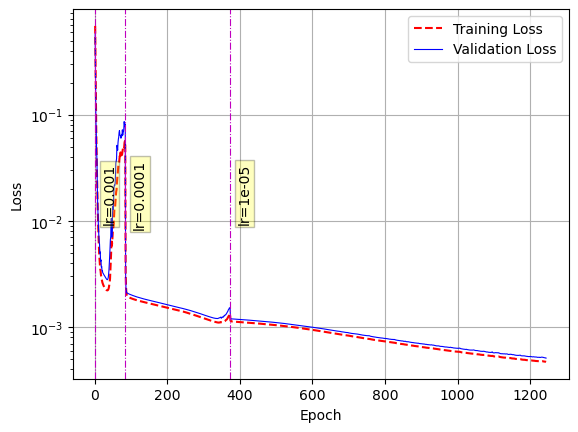

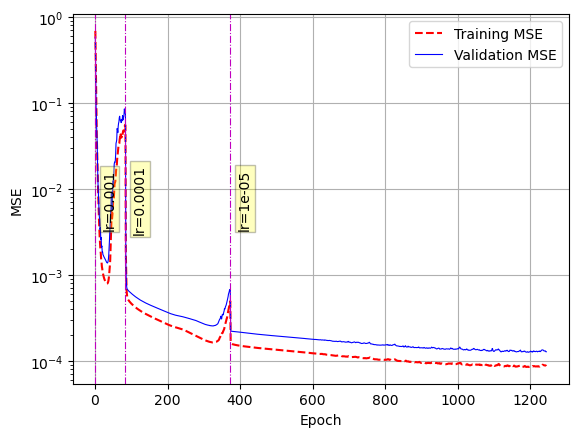

<Figure size 640x480 with 0 Axes>

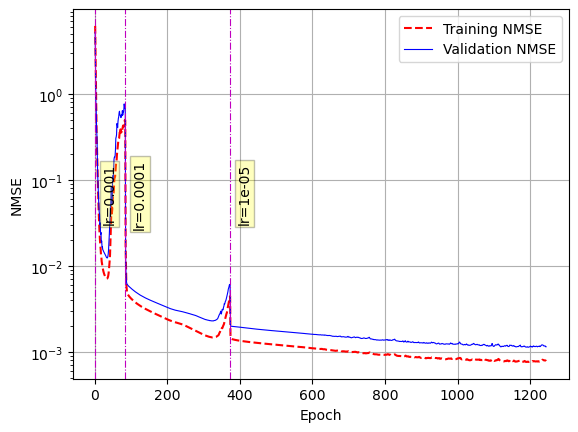

<Figure size 640x480 with 0 Axes>

In [46]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


In [47]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])



data_idx : 29


In [48]:
prediction.shape, data_out.shape, rnn_net.stateful

((16, 100, 169), (100, 169), True)

In [49]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(data.shape[-1]):
    #     new_data[:, i] -= normalization_arr[0, i]
    #     new_data[:, i] /= normalization_arr[1, i]
    new_data -= normalization_arr[0]
    new_data *= normalization_arr[1]
    
    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(shape[-1]):
    #     if len(shape) == 2:
    #         new_data[:, i] *= normalization_arr[1, i]
    #         new_data[:, i] += normalization_arr[0, i]
    #     elif len(shape) == 3:
    #         new_data[:, :, i] *= normalization_arr[1, i]
    #         new_data[:, :, i] += normalization_arr[0, i]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

In [50]:
lyapunov_time_arr = [1/0.065]

In [51]:
normalization_arr

array([[-0.7499788 , -0.7498613 , -0.74918306, -0.74818593, -0.74709743,
        -0.74625283, -0.7458057 , -0.7456656 , -0.7459548 , -0.74685055,
        -0.74789417, -0.7488208 , -0.7495427 , -0.74932796, -0.7491606 ,
        -0.74844015, -0.7474818 , -0.7467681 , -0.74608016, -0.74552155,
        -0.7454448 , -0.74567986, -0.7464409 , -0.7475862 , -0.74854803,
        -0.7491308 , -0.748854  , -0.74867165, -0.7480509 , -0.74722487,
        -0.74631286, -0.74560803, -0.74520135, -0.74532217, -0.7458373 ,
        -0.7464164 , -0.74719167, -0.74771756, -0.74834645, -0.7483056 ,
        -0.74854594, -0.74815845, -0.74714154, -0.74580866, -0.7449367 ,
        -0.74464566, -0.7446485 , -0.7449305 , -0.7454133 , -0.7462478 ,
        -0.7470165 , -0.7477161 , -0.74833983, -0.74815416, -0.7475827 ,
        -0.7468359 , -0.7460861 , -0.7454329 , -0.74501   , -0.74485224,
        -0.7448271 , -0.74547684, -0.74661225, -0.7474208 , -0.7479944 ,
        -0.74845165, -0.74834615, -0.74777526, -0.7

# Autoregressive Mode

In [52]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [53]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [54]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [55]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2047
data_.shape : (1, 677, 169)


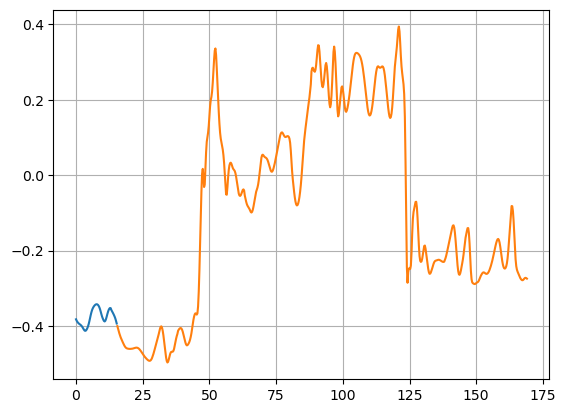

In [56]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(
    dt_rnn*np.arange(num_sample_input_AR),
    data_[0, 0:num_sample_input_AR, 0])
plt.plot(
    dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR),
    data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [57]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

if data_.shape[0] != batch_size:
    data_ = np.tile(data_, (batch_size,)+tuple([1]*len(data_.shape[1:])))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR]))

prediction_lst.append(input_preds[:, -1:])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1])

In [58]:
prediction_lst = np.stack(prediction_lst)[:, 0, 0]
input_preds = input_preds[0]

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 169)
prediction_lst.shape : (615, 169)


In [59]:
input_preds = input_preds.reshape(input_preds.shape[0], -1)
prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 169)
prediction_lst.shape : (615, 169)


Only plotting the first 32 latent states because of memory constraints.
0.6987500000000001


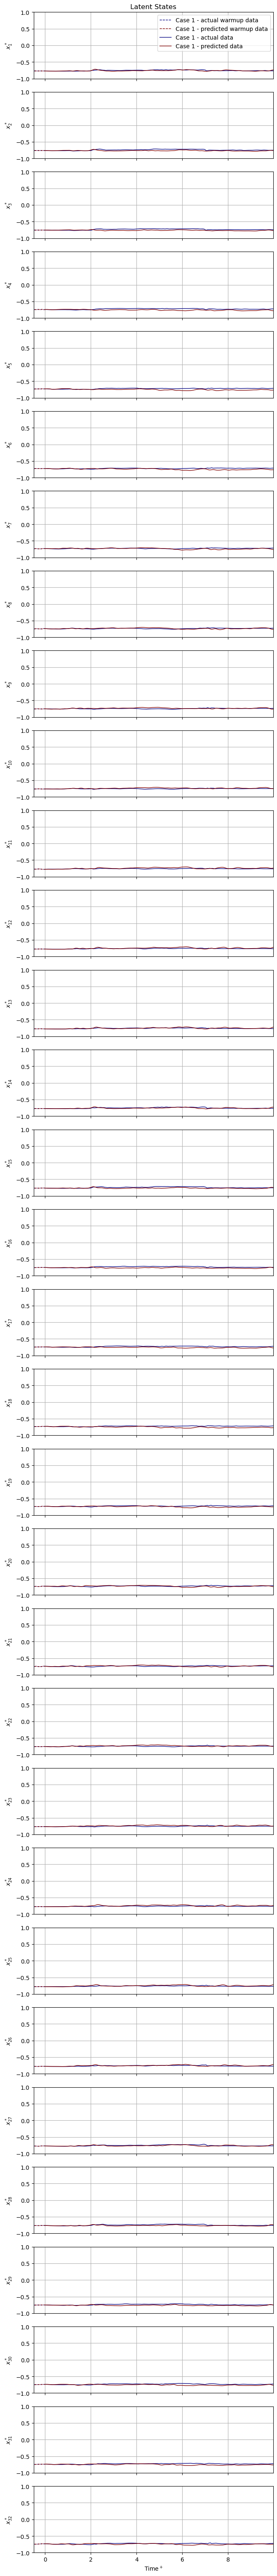

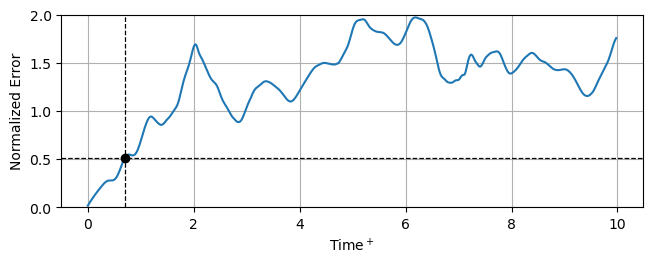

In [60]:
lyap_time = (1/0.065)# np.mean(lyapunov_time_arr)

n = 1
num_latent_states = 32#input_preds.shape[-1]# *input_preds.shape[-2]*input_preds.shape[-3]
N = num_sample_output_AR#num_output_timesteps

if num_latent_states != input_preds.shape[-1]:
    print('Only plotting the first {} latent states because of memory constraints.'.format(num_latent_states))

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

temp_ = data_[0, 0:num_sample_input_AR+N]
temp_ = temp_.reshape(temp_.shape[0], -1)
temp_ = invert_normalization(temp_, normalization_arr)
prediction_lst = invert_normalization(prediction_lst, normalization_arr)
input_preds = invert_normalization(input_preds, normalization_arr)
for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, temp_[:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, temp_[num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(rnn_data_boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (temp_[num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [61]:
try:
    if use_weights_post_dense == True:
        print(rnn_net.postWout.individual_weights)
except:
    pass

### Prediction horizon computation

In [62]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [63]:
normalization_arr.shape, time_stddev.shape

((2, 169), (169,))

In [64]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print('num_runs : {}'.format(num_runs))

num_runs : 100


In [65]:
data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

jj_max = int(num_runs // batch_size)
data_ = np.empty(shape=(batch_size, num_sample_input_AR+num_sample_output_AR)+tuple(data_in.shape[2:]))
for jj in range(jj_max):
    data_idxs = data_idx_arr[batch_size*jj:batch_size*(jj+1)]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = (1/0.065)#lyapunov_time_arr[0]

    ### picking the data
    for i in range(batch_size):
        data_[i] = data_in[0, data_idxs[i]:data_idxs[i]+(num_sample_input_AR+num_sample_output_AR)]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.rnn_list:
        layer.reset_states()

    input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR], training=False))

    prediction_lst.append(input_preds[:, -1:])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array(prediction_lst[-1])
        output = np.array(rnn_net(data_in_j, training=False))
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)[:, :, 0]
    prediction_lst = np.transpose(prediction_lst, (1, 0, 2))
    prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], prediction_lst.shape[1], -1)
    prediction_lst = invert_normalization(prediction_lst, normalization_arr) # don't invert if using time_stddev in error
    
    data_out = data_[:, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR]
    data_out = data_out.reshape(data_out.shape[0], data_out.shape[1], -1)
    data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out - prediction_lst)**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = error / time_stddev_AEproducedlatentstates**2
    error = np.mean(error, axis=-1)**0.5

    for i in range(batch_size):
        predhor_idx = np.where(error[i] >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[1]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[jj*batch_size+i] = predhor_idx*dt_rnn/lyap_time

if num_runs > jj_max*batch_size:
    for jj in range(jj_max*batch_size, num_runs):
        data_idx = data_idx_arr[jj]

        # for j in range(len(rnn_data_boundary_idx_arr)):
        #     if data_idx < rnn_data_boundary_idx_arr[j]:
        #         case_idx = j
        #         break
        lyap_time = (1/0.065)#lyapunov_time_arr[0]

        ### picking the data
        for i in range(batch_size):
            data_[i] = data_in[0, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR)]

        ### doing the predictions
        prediction_lst = []

        for layer in rnn_net.rnn_list:
            layer.reset_states()

        input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR], training=False))

        prediction_lst.append(input_preds[:, -1:])

        for j in range(1, num_sample_output_AR):
            data_in_j = np.array(prediction_lst[-1])
            output = np.array(rnn_net(data_in_j, training=False))
            prediction_lst.append(output)
        prediction_lst = np.stack(prediction_lst)[:, 0, 0]
        prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)
        prediction_lst = invert_normalization(prediction_lst, normalization_arr) # don't invert if using time_stddev in error

        data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR]
        data_out = data_out.reshape(data_out.shape[0], -1)
        data_out = invert_normalization(data_out, normalization_arr)

        ### Error and prediction horizon
        # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
        error = (data_out - prediction_lst)**2
        # error /= norm_sq_time_average(data_out)**0.5
        error = error / time_stddev_AEproducedlatentstates**2
        error = np.mean(error, axis=-1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[jj] = predhor_idx*dt_rnn/lyap_time
        
median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

saved_ESN/ESN_004

error_threshold = 0.5
prediction_horizon : 0.5898750000000001, median : 0.5687500000000001
ph_min : 0.08125, ph_max : 1.7225000000000001
stddev : 0.25768934179550385, IQR : 0.26000000000000006
1st quartile : 0.43875000000000003, 3rd quartile : 0.6987500000000001
analysis time : 60.88910722732544 s

